In [2]:
!python -m pip install protobuf==5.28.3
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras as keras
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from PIL import Image
import pickle
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard

from sklearn.model_selection import train_test_split
import random
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
# Bleu score is used to evaluate the effectiveness of generated text and is calculated with the following equation
# BLEU SCORE = BP (Brevity Penalty) * exp(∑(w * ln(p)) from i = 1 to N)
# w -> the given weight of each n-gram precision in order
# p -> The ratio between the number of n-grams in the produced sequence that match that of the validation sequence and the total number of n-grams in the produced sequence
# BP = exp(1 - (r / c)) where r is the length of the produced sequence and c is the average length of the validation sequence
# N -> Maximum n-gram order to consider
# The default value of N is 4 (4 word max sequence to consider)

tf.random.set_seed(42) # Does anybody get the reference?
np.random.seed(42)
random.seed(42)

BATCH_SIZE = 64
IMAGE_SIZE = (224, 224)
ABSOLUTE_MAX_CAPTION_LENGTH = 40
MAX_VOCAB_SIZE = 5000
EMBEDDING_DIM = 256 # The amount of attributes per word (i.e how many numbers does it take to represent a word)
LSTM_UNITS = 256
DROPOUT_RATE = 0.4 # Reduces overfitting by removing extraneous nodes
LEARNING_RATE = 0.001 # Self-explanatory

In [4]:
@keras.saving.register_keras_serializable() # Allows for these custom classes to be serializable in order for them to be saved in .keras file
class ChannelAttention(layers.Layer): # Refers to the CNN attention module that represents the different color channels (like RGB) in the image
    def __init__(self, ratio=8, **kwargs):
        super(ChannelAttention, self).__init__(**kwargs)
        self.ratio = ratio
        self.gap = layers.GlobalAveragePooling1D() # Converts variable length matrices into one array (1-D) by taking the average of each column
        self.gmp = layers.GlobalMaxPooling1D() # Does the same but using the max of each column
        self.shared_mlp = tf.keras.Sequential([ # MLP stands for Multilayer Perceptron
            layers.Dense(units=1280 // self.ratio, activation='relu'),
            layers.Dense(units=1280) # Units refer to dimesionality
        ])
        self.sigmoid = layers.Activation('sigmoid')
        # Activation functions are used to decide when to activate given nodes based on a given mathematical function and the inputs

    def get_config(self): # Allows for keras to recreate this custom layer for serialization
        config = super(ChannelAttention, self).get_config()
        config.update({"ratio": self.ratio})
        return config

    def build(self, input_shape): # Used to instantiate weights and biases for custom layer
        channel_dim = input_shape[-1]
        self.shared_mlp.add(layers.Dense(units = channel_dim // self.ratio, activation='relu'))
        self.shared_mlp.add(layers.Dense(units = channel_dim))
        self.shared_mlp.build((None, channel_dim))  # Build with expected input shape

    def call(self, inputs): # Used to build dataflow graph for tensorflow to use for the custom layer
        gap = self.gap(inputs)
        gmp = self.gmp(inputs)

        gap_mlp = self.shared_mlp(gap)
        gmp_mlp = self.shared_mlp(gmp)

        channel_attention = self.sigmoid(gap_mlp + gmp_mlp)
        return inputs * channel_attention[:, None, :]

@keras.saving.register_keras_serializable()
class SpatialAttention(layers.Layer): # Refers to the CNN attention module that represents the width and height of each image
    def __init__(self, **kwargs):
        super(SpatialAttention, self).__init__(**kwargs)
        self.conv = layers.Conv1D(1, kernel_size = 3, padding = 'same', activation = 'sigmoid') # Kernel Size refers to the length of each sliding window (kernel) in CNN used for feature extraction

    def get_config(self): # Allows for keras to recreate this custom layer for serialization
        return super(SpatialAttention, self).get_config()

    def build(self, input_shape): # Used to instantiate weights and biases for custom layer
        # Conv1D expects shape: (batch_size, time_steps, channels)
        self.conv.build(input_shape)

    def call(self, inputs): # Used to build dataflow graph for tensorflow to use for the custom layer
        spatial_attention = self.conv(inputs)
        return inputs * spatial_attention

In [5]:
def load_and_clean_captions(caption_path):
    captions = {}
    with open(caption_path, encoding = "utf-8") as f:
        next(f)  # Skip header
        for line in f:
            if not line.strip(): # Check for whitespace
                continue
            sections = line.strip().split(',') # Removes whitespace and isolates caption phrase
            if len(sections) < 2:
                continue
            image_id = sections[0].split('.')[0] # Isolates image id from .jpg extension
            caption = ','.join(sections[1:]).strip().lower()

            caption = ' '.join([word for word in caption.split()
                              if word.isalpha() or word in ['.', ',', '!', '?']])

            caption = 'start ' + caption + ' end' # Add start and end markers for each caption

            if image_id not in captions: # Check for repeat ids
                captions[image_id] = []
            captions[image_id].append(caption)
    return captions

captions = load_and_clean_captions("C:/Users/sbodd/archive (1)/captions.txt")
image_ids = list(captions.keys()) # Indexes are keys
train_ids, test_ids = train_test_split(image_ids, test_size = 0.2, random_state = 42) # 80-20 training/testing split

In [6]:
class FeatureExtractor:

    def __init__(self, weights_path=None):
        self.model = None
        self.weights_path = weights_path

    def get_model(self):
        if self.model is None:
            base_model = EfficientNetV2B0(
                weights = self.weights_path if self.weights_path else 'imagenet', # Imagenet set to default
                include_top = False,
                pooling = 'avg'
            )
            self.model = models.Model( # Using base model functionality
                inputs = base_model.input,
                outputs = base_model.output
            )
            self.model.trainable = False
        return self.model

    def extract_features(self, image_path, image_id, distorter=False):
        try:
            img = Image.open(os.path.join(image_path, image_id + '.jpg'))

            if distorter: # Used to train for abnormalities in images by purposefully distorting images at random
                if random.random() > 0.5:
                    img = img.transpose(Image.FLIP_LEFT_RIGHT) # Flips image horizontally from left to right
                if random.random() > 0.8:
                    img = img.rotate(random.uniform(-10, 10)) # Rotates image by between -10 and 10 degrees

            img = img.resize(IMAGE_SIZE)
            img = np.array(img) # Converts image to an array with shape that is such in format: (height, width, the amount of color channels (3 for RGB))

            if len(img.shape) == 2:
                img = np.stack((img,)*3, axis = -1) # Adds the representation of color channels if there are none
            elif img.shape[2] == 4:
                img = img[:, :, :3] # If there are 4 color channels, then this would force 3 color channels

            img = img.reshape((1, *img.shape))
            img = tf.keras.applications.efficientnet_v2.preprocess_input(img) # Preprocessing
            features = self.get_model().predict(img, verbose=0) # Predicting base features using base model
            return features[0]

        except Exception as e:
            return None

feature_extractor = FeatureExtractor()

In [7]:
def create_tokenizer(captions, vocab_size = MAX_VOCAB_SIZE):
    all_captions = []
    for image_id in captions: # Adds captions to the list
        all_captions.extend(captions[image_id])

    tokenizer = Tokenizer(
        num_words = vocab_size, # Make tokenizer consider the 5000 most common words
        oov_token = '<unk>', # Default token to replace words that would excess VOCAB_SIZE (unk stands for unknown)
        filters = ''
    )

    tokenizer.fit_on_texts(all_captions) # Tokenizes captions

    max_len = max(len(caption) for caption in all_captions)
    max_len = min(max_len, ABSOLUTE_MAX_CAPTION_LENGTH) # Insures that the maximum length of each caption (regardless of dataset) is at or below its absolute maximum

    return tokenizer, max_len

tokenizer, max_len = create_tokenizer(captions)
vocab_size = min(len(tokenizer.word_index) + 1, MAX_VOCAB_SIZE) # The +1 is to account for the fact that the tokenizer maxes out the vocabulary size to (nums_words - 1)

In [8]:
class CaptioningDataGenerator(tf.keras.utils.Sequence):
  def __init__(self, image_ids, captions, tokenizer, max_length, vocab_size, batch_size, image_path, distorter = False, **kwargs):
    super().__init__(**kwargs)
    self.image_ids = image_ids
    self.captions = captions
    self.tokenizer = tokenizer
    self.max_length = max_length
    self.vocab_size = vocab_size
    self.batch_size = batch_size
    self.image_path = image_path
    self.distorter = distorter
    self.feature_cache = {}

  def __len__(self): # Amount of epochs
    return int(np.ceil(len(self.image_ids) / self.batch_size))

  def __getitem__(self, index):
    batch_ids = self.image_ids[index * self.batch_size : (index + 1) * self.batch_size] # Generates appropriate amount of batch_ids (image_ids for the batch) based on given index (index 0 for first batch, etc.)
    X1, X2, y = [], [], []

    for image_id in batch_ids:
      if image_id not in self.feature_cache: # Adds features from image if image is new
        features = feature_extractor.extract_features(self.image_path, image_id, distorter = self.distorter)
        if features is not None: # Adds features into feature cache
          self.feature_cache[image_id] = features
        else:
          continue

      features = self.feature_cache[image_id]

      for caption in self.captions[image_id]:
        seq = self.tokenizer.texts_to_sequences([caption])[0] # The brackets around the string sequences (the variables caption, in_seq, etc.) is to create a list with one item since the respective methods only accept lists
        for i in range(1, len(seq)):
          in_seq, out_seq = seq[:i], seq[i] # Split sequence into in and out (input and output for model)
          in_seq = pad_sequences([in_seq], maxlen = self.max_length)[0] # Force that sequence to be within max_length
          out_seq = tf.keras.utils.to_categorical([out_seq], num_classes = self.vocab_size)[0] # Convert out_seq to binary matrix (each row represents each element in binary)
          X1.append(features)
          X2.append(in_seq)
          y.append(out_seq)

    if len(X1) == 0:
      return self.__getitem__((index + 1) % self.__len__()) # Redo with another batch if no features are found

    indices = np.arange(len(X1)) # Randomly shuffle X1, X2, and y to prevent overfitting
    np.random.shuffle(indices)

    X1 = np.array(X1)[indices]
    X2 = np.array(X2)[indices]
    y = np.array(y)[indices]

    return (X1, X2), y

# Make train and test generators with the distorter active only for training
train_generator = CaptioningDataGenerator(
    train_ids, {k : captions[k] for k in train_ids}, tokenizer, max_len, vocab_size, BATCH_SIZE, "C:/Users/sbodd/archive (1)/Images/flickr30k_images", distorter = True
)
test_generator = CaptioningDataGenerator(
    test_ids, {k : captions[k] for k in test_ids}, tokenizer, max_len, vocab_size, BATCH_SIZE, "C:/Users/sbodd/archive (1)/Images/flickr30k_images", distorter = False
)

In [7]:
def create_improved_model(vocab_size, max_length):
  # Image feature processing with dual attention (spatial and channel)

  feature_input = layers.Input(shape = (1280, )) # 1280 is to match the amount of units for the dense layer

  reshaped = layers.Reshape((1, 1280))(feature_input)

  channel_attention = ChannelAttention()(reshaped)
  spatial_attention = SpatialAttention()(channel_attention)

  attented_features = layers.Flatten()(spatial_attention)

  fe1 = layers.Dropout(DROPOUT_RATE)(attented_features) # Feature engineering by dropping certain extraneous features (setting random input units to 0)
  fe2 = layers.Dense(512, activation = 'relu')(fe1)
  fe3 = layers.Dropout(DROPOUT_RATE)(fe2)
  fe4 = layers.Dense(256, activation = 'relu')(fe3)

  in_seq_input = layers.Input(shape = (max_length, ))

  se1 = layers.Embedding(vocab_size, EMBEDDING_DIM, mask_zero = False)(in_seq_input) # Embedding layers (translating semantic meaning to vectors)
  se2 = layers.Dropout(DROPOUT_RATE)(se1)
  se3 = layers.Bidirectional(layers.LSTM(LSTM_UNITS))(se2) # Uses LSTM to consider present, past, and future features for better semantic context

  decoder1 = layers.Concatenate()([fe4, se3]) # Decoding inputs to outputs (features to captions)
  decoder2 = layers.Dense(512, activation = 'relu')(decoder1)
  decoder3 = layers.Dropout(DROPOUT_RATE)(decoder2)
  decoder4 = layers.Dense(256, activation = 'relu')(decoder3)
  out_seq_outputs = layers.Dense(vocab_size, activation = 'softmax')(decoder4)

  model = models.Model(inputs = [feature_input, in_seq_input], outputs = out_seq_outputs)

  optimizer = optimizers.Adam(
      learning_rate = LEARNING_RATE
  )

  model.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
  # Categorical cross-entropy is a method for calculating loss with the following formula:
  # Loss = -(∑(log(p)) from i = 1 to C)
  # p -> The probability predicted for the right translation in decimal form (0 to 1)
  # C -> The amount of classes (images in this case)

  return model

model = create_improved_model(vocab_size, max_len)
model.save("C:/Users/sbodd/Projects/Machine Learning Projects/Checkpoints/captioning_model.keras") # Check if serialization works
model = models.load_model("C:/Users/sbodd/Projects/Machine Learning Projects/Checkpoints/captioning_model.keras", compile = False)
model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=LEARNING_RATE), metrics=['accuracy'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 1280)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ reshape (Reshape)             │ (None, 1, 1280)           │               0 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ channel_attention             │ (None, 1, 1280)           │         822,080 │ reshape[0][0]              │
│ (ChannelAttention)            │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ spatial_attention             │ (None, 1, 1280)           │           3,841 │ channel_attention[0][0]    │
│ (SpatialAttention)            │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten (Flatten)             │ (None, 1280)              │               0 │ spatial_attention[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout (Dropout)             │ (None, 1280)              │               0 │ flatten[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_2 (InputLayer)    │ (None, 40)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_4 (Dense)               │ (None, 512)               │         655,872 │ dropout[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding (Embedding)         │ (None, 40, 256)           │       1,280,000 │ input_layer_2[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_1 (Dropout)           │ (None, 512)               │               0 │ dense_4[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_2 (Dropout)           │ (None, 40, 256)           │               0 │ embedding[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_5 (Dense)               │ (None, 256)               │         131,328 │ dropout_1[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bidirectional (Bidirectional) │ (None, 512)               │       1,050,624 │ dropout_2[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate (Concatenate)     │ (None, 768)               │               0 │ dense_5[0][0],             │
│                               │                           │                 │ bidirectional[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_6 (Dense)               │ (None, 512)               │         393,728 │ concatenate[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_3 (Dropout)           │ (None, 512)               │               

 Total params: 5,753,801 (21.95 MB)

 Trainable params: 5,753,801 (21.95 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
callbacks = [
    ModelCheckpoint( # Save model when validation data loss is minimized
        filepath = 'C:/Users/sbodd/Projects/Machine Learning Projects/Checkpoints/captioning_model.keras',
        monitor = 'val_loss',
        save_best_only = True,
        mode = 'min',
        verbose = 1 # Will show warnings if specific callback is used
    ),
    EarlyStopping( # Will stop after 7 epochs with no improvement in loss
        monitor = 'val_loss',
        patience = 7,
        restore_best_weights = True,
        verbose = 1
    ),
    ReduceLROnPlateau( # Reduce learning rate by a factor of 0.1 if there is no improvement in loss in 3 epochs
        monitor = 'val_loss',
        factor = 0.1,
        patience = 3,
        min_lr = 1e-7,
        verbose = 1
    ),
    TensorBoard( # Computes histograms (visuals for weights and bias) in each epoch but does not show them and also logs events in tensorboard (log_dir = 'logs')
        histogram_freq = 1
    )
] 

history = model.fit(
    train_generator,
    epochs = 20,
    validation_data = test_generator,
    callbacks = callbacks,
    batch_size = BATCH_SIZE,
    verbose = 1 # Will show progress bar
)

Epoch 1/20
398/398 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - accuracy: 0.2084 - loss: 4.9995 
Epoch 1: val_loss improved from None to 3.56692, saving model to C:/Users/sbodd/Projects/Machine Learning Projects/Checkpoints/captioning_model.keras
398/398 ━━━━━━━━━━━━━━━━━━━━ 7337s 18s/step - accuracy: 0.2738 - loss: 4.2864 - val_accuracy: 0.3403 - val_loss: 3.5669 - learning_rate: 0.0010
Epoch 2/20
398/398 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.3457 - loss: 3.5013
Epoch 2: val_loss improved from 3.56692 to 3.19055, saving model to C:/Users/sbodd/Projects/Machine Learning Projects/Checkpoints/captioning_model.keras
398/398 ━━━━━━━━━━━━━━━━━━━━ 3479s 9s/step - accuracy: 0.3557 - loss: 3.4093 - val_accuracy: 0.3787 - val_loss: 3.1905 - learning_rate: 0.0010
Epoch 3/20
398/398 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.3752 - loss: 3.1878
Epoch 3: val_loss improved from 3.19055 to 3.04336, saving model to C:/Users/sbodd/Projects/Machine Learning Projects/Checkpoints/captioning_model.keras


Displaying sample results...


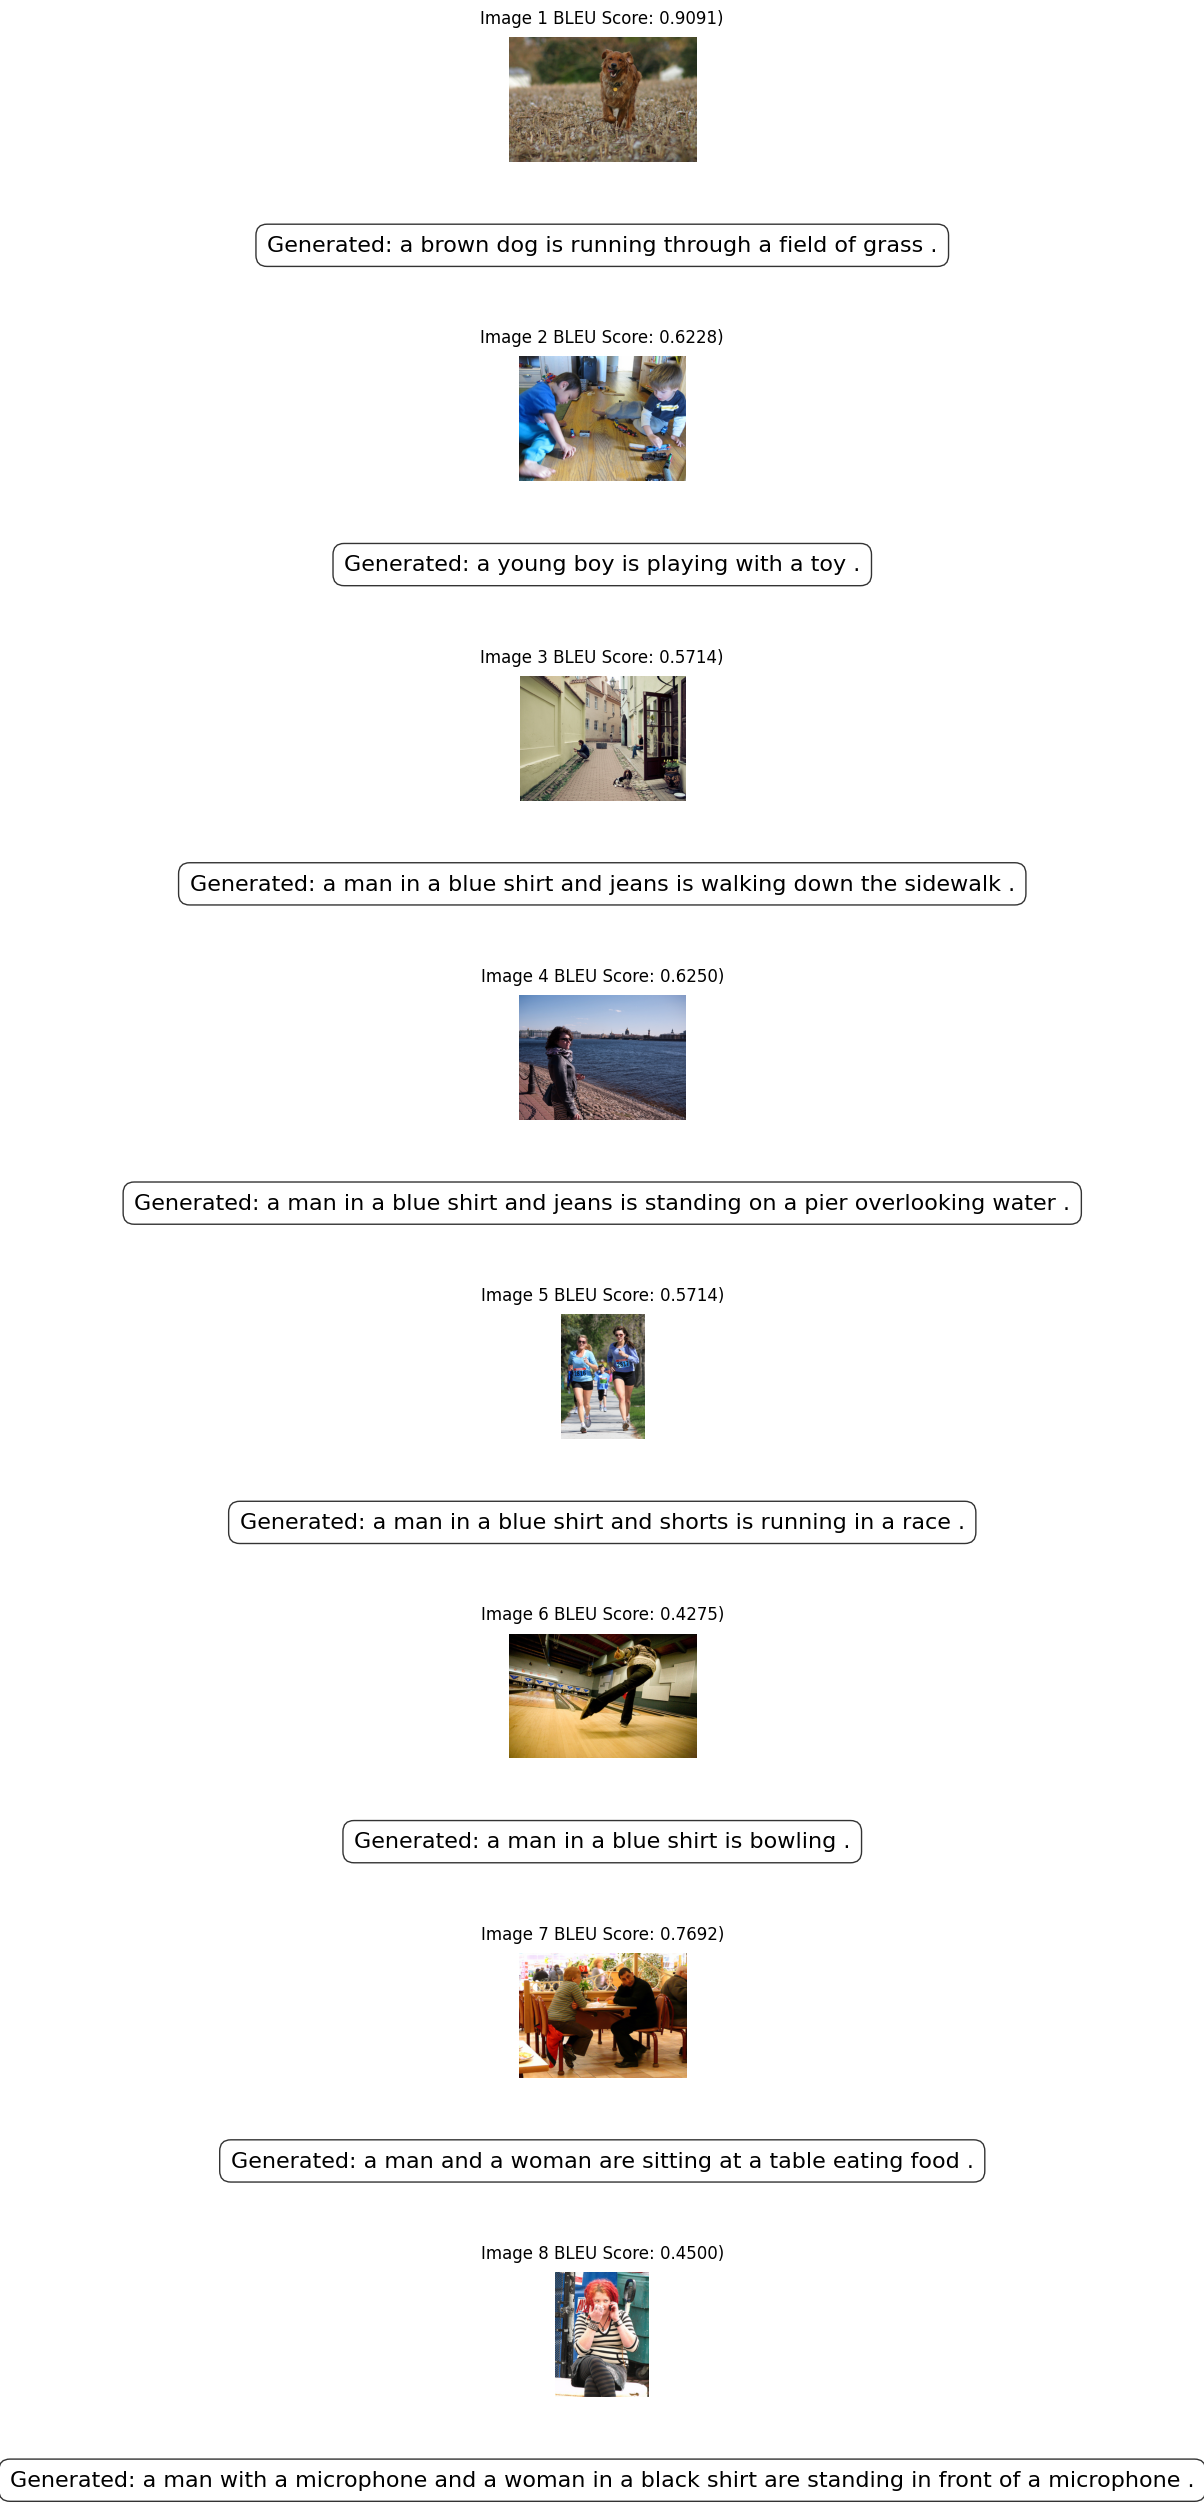


Evaluating model on test set...


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 600/600 [09:52<00:00,  1.01it/s]



Model Evaluation Results:
BLEU-1: 0.9005
BLEU-2: 0.8053
BLEU-3: 0.7019
BLEU-4: 0.6114

Training and evaluation complete!


In [23]:
# Installs requisite dependencies
!python -m pip install tqdm
from tqdm import tqdm
from nltk.translate.bleu_score import corpus_bleu

model = models.load_model("C:/Users/sbodd/Projects/Machine Learning Projects/Checkpoints/captioning_model.keras")
image_path = "C:/Users/sbodd/archive (1)/Images/flickr30k_images"
smoother = SmoothingFunction().method1 # Variably adjusts n-gram precision order for bleu score (like switching from matching two words to four)
samples = 8 # Amount of testing samples

def generate_caption(model, tokenizer, image_features, max_length):
    input_text = "start"
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([input_text])[0] 
        sequence = pad_sequences([sequence], maxlen = max_length)
        est_linear_eq = model.predict([np.array([image_features]), sequence], verbose = 0)  
        # Initiates single word prediction and outputs in a format akin to a estimated linear equation (y = mx + b) also known as yhat

        wordIndex = np.argmax(est_linear_eq) # Extract index from prediction result
        predicted_word = tokenizer.index_word.get(wordIndex, None) # Generate word based on predicted index
        if predicted_word is None or predicted_word == "end":
            break
        input_text += " " + predicted_word # Repeat cycle to generate next word in caption
    return input_text.replace("start ", "") # Remove start sequence marker from caption

def display_results(model, tokenizer, test_ids, captions, max_length, n = samples):
    fig = plt.figure(figsize = (25, 25), constrained_layout = True)

    grid = fig.add_gridspec(n * 2, 1, height_ratios = [3, 1] * n, hspace = 0.4) # Generate appropriate grid space for examples

    displayed_images = 0
    attempts = 0
    max_attempts = min(200, len(test_ids)) # Minimum of 200 (or the amount of test_ids) possible attempts for 8 images

    while displayed_images < n and attempts < max_attempts:
        attempts += 1
        image_id = random.choice(test_ids) # Pick random image from testing dataset
        features = feature_extractor.extract_features(image_path, image_id)
        if features is None: # Redo feature extraction if failed
            continue

        generated_caption = generate_caption(model, tokenizer, features, max_length)
        validation_captions = [c.replace("start ", "").replace("end ", "") for c in captions[image_id]] 
        # Gets the 3 human-made captions for each respective image for validation

        generated_words = generated_caption.split() # Split caption into words for bleu score evaluation
        validation_words = [caption.split() for caption in validation_captions]

        bleu_score = sentence_bleu(validation_words, generated_words, weights = (1, 0, 0, 0), smoothing_function = smoother)
        # Calculates bleu score based solely on unigrams (single word matching)

        image_axis = fig.add_subplot(grid[displayed_images * 2])
        image = Image.open(os.path.join(image_path, image_id + ".jpg"))
        image_array = np.array(image)

        image_aspect_ratio = image_array.shape[0] / image_array.shape[1] # Width / height

        if image_aspect_ratio < 1.5: # Check for wide image and add space to fit image
            fig.set_size_inches(12, fig.get_size_inches()[1]) # Keeps height the same and changes width to 12 inches

        image_axis.imshow(image)
        
        image_axis.axis("off") # Adds object to display images
        image_axis.set_title(f"Image {displayed_images + 1} BLEU Score: {bleu_score:.4f})", pad = 10) # Add title for image with score

        caption_axis = fig.add_subplot(grid[displayed_images * 2 + 1]) # Adds object to display captions
        caption_axis.axis("off")

        caption_text = f"Generated: {generated_caption}"

        caption_axis.text(0.5, 0.5, caption_text, ha = "center", va = "center", fontsize = 16, 
                          bbox = dict(facecolor = "white", alpha = 0.8, boxstyle = "round, pad = 0.5"))
        # Displays captions with center alignment and bounding box defined with characteristics in a dictionary

        displayed_images += 1

    if displayed_images == 0:
        print("No images found")
    else:
        plt.show()

print("Displaying sample results...")
display_results(model, tokenizer, test_ids, captions, max_len)

def evaluate_model(model, tokenizer, test_ids, captions, max_length, sample_size = 600):
    actual_captions, predicted_captions = [], []
    test_subset = test_ids[:sample_size]

    for image_id in tqdm(test_subset, desc = "Evaluating"): # tqdm generates a progress bar for iterative loop

        features = feature_extractor.extract_features(image_path, image_id) # Same process to generate captions as previously
        if features is None:
            continue

        yhat = generate_caption(model, tokenizer, features, max_length)
        references = [c.replace('startseq ', '').replace(' endseq', '') for c in captions[image_id]]

        actual_captions.append(references)
        predicted_captions.append(yhat)

    # Corpus bleu is a modified version of bleu score that works on entire sentences (the entire caption in this case)
    bleu1 = corpus_bleu(actual_captions, predicted_captions, weights = (1, 0, 0, 0), smoothing_function = smoother)
    bleu2 = corpus_bleu(actual_captions, predicted_captions, weights = (0.5, 0.5, 0, 0), smoothing_function = smoother)
    bleu3 = corpus_bleu(actual_captions, predicted_captions, weights = (0.33, 0.33, 0.33, 0), smoothing_function = smoother)
    bleu4 = corpus_bleu(actual_captions, predicted_captions, weights = (0.25, 0.25, 0.25, 0.25), smoothing_function = smoother)

    print("\nModel Evaluation Results:")
    print(f"BLEU-1: {bleu1:.4f}") # Bleu Score focuses only on unigrams
    print(f"BLEU-2: {bleu2:.4f}") # Bleu Score focuses equally on both unigrams and bigrams
    print(f"BLEU-3: {bleu3:.4f}") # Bleu Score focuses equally on unigrams, bigrams, and trigrams
    print(f"BLEU-4: {bleu4:.4f}") # Bleu Score focuses equally on unigrams, bigrams, trigrams, and 4-grams

    return bleu1, bleu2, bleu3, bleu4

print("\nEvaluating model on test set...")
bleu_scores = evaluate_model(model, tokenizer, test_ids, captions, max_len)
print("\nTraining and evaluation complete!")